# **Importing Necessary Libraries**

In [ ]:
# essentials
import numpy as np 
import pandas as pd 

# plotting
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
matplotlib.rcParams['figure.dpi'] = 100
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.set(style="whitegrid")
%matplotlib inline

# ml
from sklearn.metrics import accuracy_score, recall_score, ConfusionMatrixDisplay, classification_report, auc, precision_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb
import joblib

# **Custom Helper Function To Find Missing Values Percentage** 

The code contains two functions:

**print_col_type(df)** - This function takes a Pandas DataFrame as an input and prints out the names of the columns in the DataFrame separated by data type. It first selects the columns in the DataFrame that are non-numeric (using the select_dtypes method with the include parameter set to 'object') and then selects the columns that are numeric (using the select_dtypes method with the exclude parameter set to 'object'). It then prints out the names of the non-numeric columns and the names of the numeric columns.

**missing_cols(df)** - This function takes a Pandas DataFrame as an input and prints out the names of columns that contain missing values along with the number of missing values and the percentage of missing values in each column. It iterates over the columns in the DataFrame, calculates the number of missing values in each column using the isnull and sum methods, and calculates the percentage of missing values using the isna and mean methods. If a column has missing values, it prints out the name of the column, the number of missing values, and the percentage of missing values. Finally, if there are no missing values in any column, it prints out "no missing values".


In [ ]:
def print_col_type(df):
    non_num_df = df.select_dtypes(include=['object'])
    num_df = df.select_dtypes(exclude=['object'])
    '''separates non-numeric and numeric columns'''
    print("Object columns:")
    for col in non_num_df:
        print(f"{col}")
    print("")
    print("Numeric columns:")
    for col in num_df:
        print(f"{col}")

def missing_cols(df):
    '''prints out columns with its amount of missing values with its %'''
    total = 0
    for col in df.columns:
        missing_vals = df[col].isnull().sum()
        pct = df[col].isna().mean() * 100
        total += missing_vals
        if missing_vals != 0:
          print('{} => {} [{}%]'.format(col, df[col].isnull().sum(), round(pct, 2)))
    
    if total == 0:
        print("no missing values")

# **Importing required datasets**

In [ ]:
train_a = pd.read_csv("/content/drive/MyDrive/Dataset/comp_datasets_train/region_A_train.csv")
train_b = pd.read_csv("/content/drive/MyDrive/Dataset/comp_datasets_train/region_B_train.csv")
train_c = pd.read_csv("/content/drive/MyDrive/Dataset/comp_datasets_train/region_C_train.csv")
train_d = pd.read_csv("/content/drive/MyDrive/Dataset/comp_datasets_train/region_D_train.csv")
train_e = pd.read_csv("/content/drive/MyDrive/Dataset/comp_datasets_train/region_E_train.csv")

test_a = pd.read_csv("/content/drive/MyDrive/Dataset/comp_datasets_test/region_A_test.csv")
test_b = pd.read_csv("/content/drive/MyDrive/Dataset/comp_datasets_test/region_B_test.csv")
test_c = pd.read_csv("/content/drive/MyDrive/Dataset/comp_datasets_test/region_C_test.csv")
test_d = pd.read_csv("/content/drive/MyDrive/Dataset/comp_datasets_test/region_D_test.csv")
test_e = pd.read_csv("/content/drive/MyDrive/Dataset/comp_datasets_test/region_E_test.csv")

labels_df = pd.read_csv("/content/drive/MyDrive/Dataset/comp_datasets_train/solution_train.csv")

In [ ]:
train_a.head()

,date,avg.temp,max.temp,min.temp,precipitation,avg.wind.speed,max.wind.speed,max.wind.speed.dir,max.inst.wind.speed,max.inst.wind.speed.dir,min.atmos.pressure
0,229b70a3,3.3,10.2,-2.4,0.0,2.9,9.3,W,14.3,W,1015.1
1,3134f4ff,5.7,13.7,-2.9,0.0,3.6,10.7,W,15.8,W,1011.3
2,dbfaf910,13.8,20.0,9.0,0.0,5.3,9.4,SW,15.2,W,1004.2
3,3aea0cf0,11.4,19.3,5.8,0.0,4.2,10.1,SW,20.6,SW,1001.7
4,f0227f56,2.4,7.7,0.3,43.5,0.9,3.7,SW,5.7,SW,1003.5


### The first thing to notice is that the date column isn’t a date but was anonymized to be some random value as per the dataset available from the source.



In [ ]:
labels_df.head()

,date,label
0,a8c6911b,N
1,eebdce12,N
2,6fb420a6,L
3,3bf8b132,N
4,e86629c2,N


### The labels_df dataframe includes labels which defines our goal of finding the category of rain on the respective anonymized dates.

# **Exploring Respective Datasets**

In [ ]:
train_a.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 566 entries, 0 to 565
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   date                     566 non-null    object 
 1   avg.temp                 566 non-null    float64
 2   max.temp                 566 non-null    float64
 3   min.temp                 566 non-null    float64
 4   precipitation            566 non-null    float64
 5   avg.wind.speed           566 non-null    float64
 6   max.wind.speed           566 non-null    float64
 7   max.wind.speed.dir       566 non-null    object 
 8   max.inst.wind.speed      566 non-null    float64
 9   max.inst.wind.speed.dir  566 non-null    object 
 10  min.atmos.pressure       566 non-null    float64
dtypes: float64(8), object(3)
memory usage: 48.8+ KB


In [ ]:
print_col_type(train_a)

Object columns:
date
max.wind.speed.dir
max.inst.wind.speed.dir

Numeric columns:
avg.temp
max.temp
min.temp
precipitation
avg.wind.speed
max.wind.speed
max.inst.wind.speed
min.atmos.pressure


# **Exploratory Data Analysis**

### Starting by concatinating all respective training dataframes in a single dataframe as the primary key is "date" column which is common in each of the training datasets.

In [ ]:
train_all = pd.concat([train_a ,train_b ,train_c ,train_d ,train_e], keys=["A", "B", "C", "D", "E"])
train_all

date  avg.temp  max.temp  min.temp  precipitation  avg.wind.speed  \
A 0    229b70a3       3.3      10.2      -2.4            0.0             2.9   
  1    3134f4ff       5.7      13.7      -2.9            0.0             3.6   
  2    dbfaf910      13.8      20.0       9.0            0.0             5.3   
  3    3aea0cf0      11.4      19.3       5.8            0.0             4.2   
  4    f0227f56       2.4       7.7       0.3           43.5             0.9   
...         ...       ...       ...       ...            ...             ...   
E 561  91b2797d       6.3      13.1       0.3            0.0             0.6   
  562  b807fd87       6.2      13.5       0.3            0.0             0.8   
  563  8e0a48e0       9.0      15.9       2.4            0.0             0.6   
  564  9df85983       5.3      13.9       0.1            0.0             1.0   
  565  c9d4fe7c       6.4      15.3      -0.2            0.0             0.7   

       max.wind.speed max.wind.speed.dir  max.inst.wind.speed  \
A 0               9.3                  W                 14.3   
  1              10.7                  W                 15.8   
  2               9.4                 SW                 15.2   
  3              10.1                 SW                 20.6   
  4               3.7                 SW                  5.7   
...               ...                ...                  ...   
E 561             2.2                  S                  4.3   
  562             2.3                 SW                  6.3   
  563             2.4                 NW                  5.7   
  564             3.0                  S                  6.9   
  565             2.1                 NW                  5.5   

      max.inst.wind.speed.dir  min.atmos.pressure  
A 0                         W              1015.1  
  1                         W              1011.3  
  2                         W              1004.2  
  3                        SW              1001.7  
  4                        SW              1003.5  
...                       ...                 ...  
E 561                       S                 NaN  
  562                       W                 NaN  
  563                       W                 NaN  
  564                      NW                 NaN  
  565                       N                 NaN  

[2830 rows x 11 columns]

**train_all_lvls = train_all.reset_index()** - This creates a new DataFrame called train_all_lvls that has a new column called "index" containing the old row labels of train_all.

**train_all_lvls.rename(columns = {"level_0": "region"}, inplace=True)** - This renames the column called "level_0" to "region" in the train_all_lvls DataFrame. 

**train_all_lvls.drop(columns=['level_1'], inplace=True)** - This drops the column called "level_1" from the train_all_lvls DataFrame. 

In [ ]:
train_all_lvls = train_all.reset_index()
train_all_lvls.rename(columns = {"level_0": "region"}, inplace=True)
train_all_lvls.drop(columns=['level_1'], inplace=True)
train_all_lvls

,region,date,avg.temp,max.temp,min.temp,precipitation,avg.wind.speed,max.wind.speed,max.wind.speed.dir,max.inst.wind.speed,max.inst.wind.speed.dir,min.atmos.pressure
0,A,229b70a3,3.3,10.2,-2.4,0.0,2.9,9.3,W,14.3,W,1015.1
1,A,3134f4ff,5.7,13.7,-2.9,0.0,3.6,10.7,W,15.8,W,1011.3
2,A,dbfaf910,13.8,20.0,9.0,0.0,5.3,9.4,SW,15.2,W,1004.2
3,A,3aea0cf0,11.4,19.3,5.8,0.0,4.2,10.1,SW,20.6,SW,1001.7
4,A,f0227f56,2.4,7.7,0.3,43.5,0.9,3.7,SW,5.7,SW,1003.5
...,...,...,...,...,...,...,...,...,...,...,...,...
2825,E,91b2797d,6.3,13.1,0.3,0.0,0.6,2.2,S,4.3,S,NaN
2826,E,b807fd87,6.2,13.5,0.3,0.0,0.8,2.3,SW,6.3,W,NaN
2827,E,8e0a48e0,9.0,15.9,2.4,0.0,0.6,2.4,NW,5.7,W,NaN
2828,E,9df85983,5.3,13.9,0.1,0.0,1.0,3.0,S,6.9,NW,NaN


### Concatinating all respective testing dataframes in a single dataframe as the primary key is "date" column which is common in each of the testing datasets.

In [ ]:
test_all = pd.concat([test_a ,test_b ,test_c ,test_d ,test_e], keys=["A", "B", "C", "D", "E"])
test_all


date  avg.temp  max.temp  min.temp  precipitation  avg.wind.speed  \
A 0    b92d713a       5.0      11.9       0.7            0.0             3.6   
  1    18817005       2.9       9.1      -1.8            0.0             3.4   
  2    8e19dc3c       9.8      18.9       0.4            0.0             3.1   
  3    6f0929dc      13.4      21.2       6.1            0.0             3.4   
  4    c7506622       9.1      16.3       2.4            0.0             2.7   
...         ...       ...       ...       ...            ...             ...   
E 373  01a1b150       6.9       9.5       4.3            1.5             0.3   
  374  90b49549       6.5      15.8      -0.1            0.0             0.6   
  375  15bc4979       7.9      10.3       3.5            9.5             0.3   
  376  b4104846       9.1      17.1       4.9           11.0             0.6   
  377  28c40b9c       7.0      17.1       0.6            0.0             0.8   

       max.wind.speed max.wind.speed.dir  max.inst.wind.speed  \
A 0              11.9                 NW                 16.7   
  1               9.6                 SW                 15.4   
  2               8.9                  W                 13.6   
  3               8.8                 SW                 13.8   
  4               7.6                 NW                 11.9   
...               ...                ...                  ...   
E 373             1.2                  S                  2.7   
  374             2.2                 SE                  4.7   
  375             1.7                 SW                  5.8   
  376             2.1                 SW                  5.8   
  377             2.8                  S                  5.2   

      max.inst.wind.speed.dir  min.atmos.pressure  
A 0                        NW              1009.2  
  1                        SW              1013.6  
  2                         W              1002.6  
  3                        SW              1003.1  
  4                        NW              1011.9  
...                       ...                 ...  
E 373                      SE                 NaN  
  374                       S                 NaN  
  375                       S                 NaN  
  376                      NW                 NaN  
  377                       S                 NaN  

[1890 rows x 11 columns]

**test_all_lvls = test_all.reset_index()** - This creates a new DataFrame called test_all_lvls that has a new column called "index" containing the old row labels of test_all.

**test_all_lvls.rename(columns = {"level_0": "region"}, inplace=True)** - This renames the column called "level_0" to "region" in the test_all_lvls DataFrame. 

**test_all_lvls.drop(columns=['level_1'], inplace=True)** - This drops the column called "level_1" from the test_all_lvls DataFrame. 

In [ ]:
test_all_lvls = test_all.reset_index()
test_all_lvls.rename(columns = {"level_0": "region"}, inplace=True)
test_all_lvls.drop(columns=['level_1'], inplace=True)
test_all_lvls.head()

,region,date,avg.temp,max.temp,min.temp,precipitation,avg.wind.speed,max.wind.speed,max.wind.speed.dir,max.inst.wind.speed,max.inst.wind.speed.dir,min.atmos.pressure
0,A,b92d713a,5.0,11.9,0.7,0.0,3.6,11.9,NW,16.7,NW,1009.2
1,A,18817005,2.9,9.1,-1.8,0.0,3.4,9.6,SW,15.4,SW,1013.6
2,A,8e19dc3c,9.8,18.9,0.4,0.0,3.1,8.9,W,13.6,W,1002.6
3,A,6f0929dc,13.4,21.2,6.1,0.0,3.4,8.8,SW,13.8,SW,1003.1
4,A,c7506622,9.1,16.3,2.4,0.0,2.7,7.6,NW,11.9,NW,1011.9


In [ ]:
train_all_lvls['region'].nunique()

5

In [ ]:
train_all_lvls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2830 entries, 0 to 2829
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   region                   2830 non-null   object 
 1   date                     2830 non-null   object 
 2   avg.temp                 2830 non-null   float64
 3   max.temp                 2830 non-null   float64
 4   min.temp                 2830 non-null   float64
 5   precipitation            2830 non-null   float64
 6   avg.wind.speed           2830 non-null   float64
 7   max.wind.speed           2830 non-null   float64
 8   max.wind.speed.dir       2830 non-null   object 
 9   max.inst.wind.speed      2830 non-null   float64
 10  max.inst.wind.speed.dir  2830 non-null   object 
 11  min.atmos.pressure       566 non-null    float64
dtypes: float64(8), object(4)
memory usage: 265.4+ KB


In [ ]:
train_all_lvls.columns[2:]

Index(['avg.temp', 'max.temp', 'min.temp', 'precipitation', 'avg.wind.speed',
       'max.wind.speed', 'max.wind.speed.dir', 'max.inst.wind.speed',
       'max.inst.wind.speed.dir', 'min.atmos.pressure'],
      dtype='object')

# **Visualizing Distribution in Target Class**

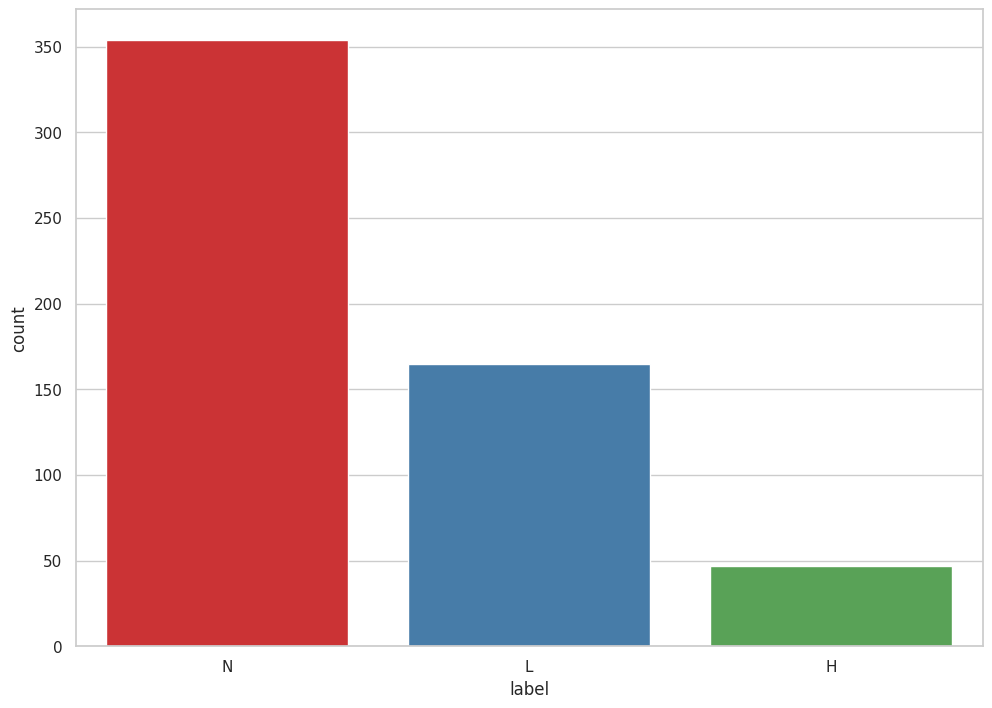

In [ ]:
sns.countplot(x = 'label', data = labels_df, palette="Set1");

### It appears there is an imbalanced class in the dataset, as the N label is dominating the rest of the classes.

### The model will be biased towards classes with a larger amount of samples.

### This happens because the classifier has more information on classes with more samples, so it learns how to predict those classes better while it remains weak on the smaller classes.

### In our case, the label "N" will be predicted more than other classes.



# **Plotting the Features of Training Datasets**

### Since all the regions are used to predict the next day’s weather, let’s see whether all the regions share similar patterns in the features and whether any outliers or anomalies exist.

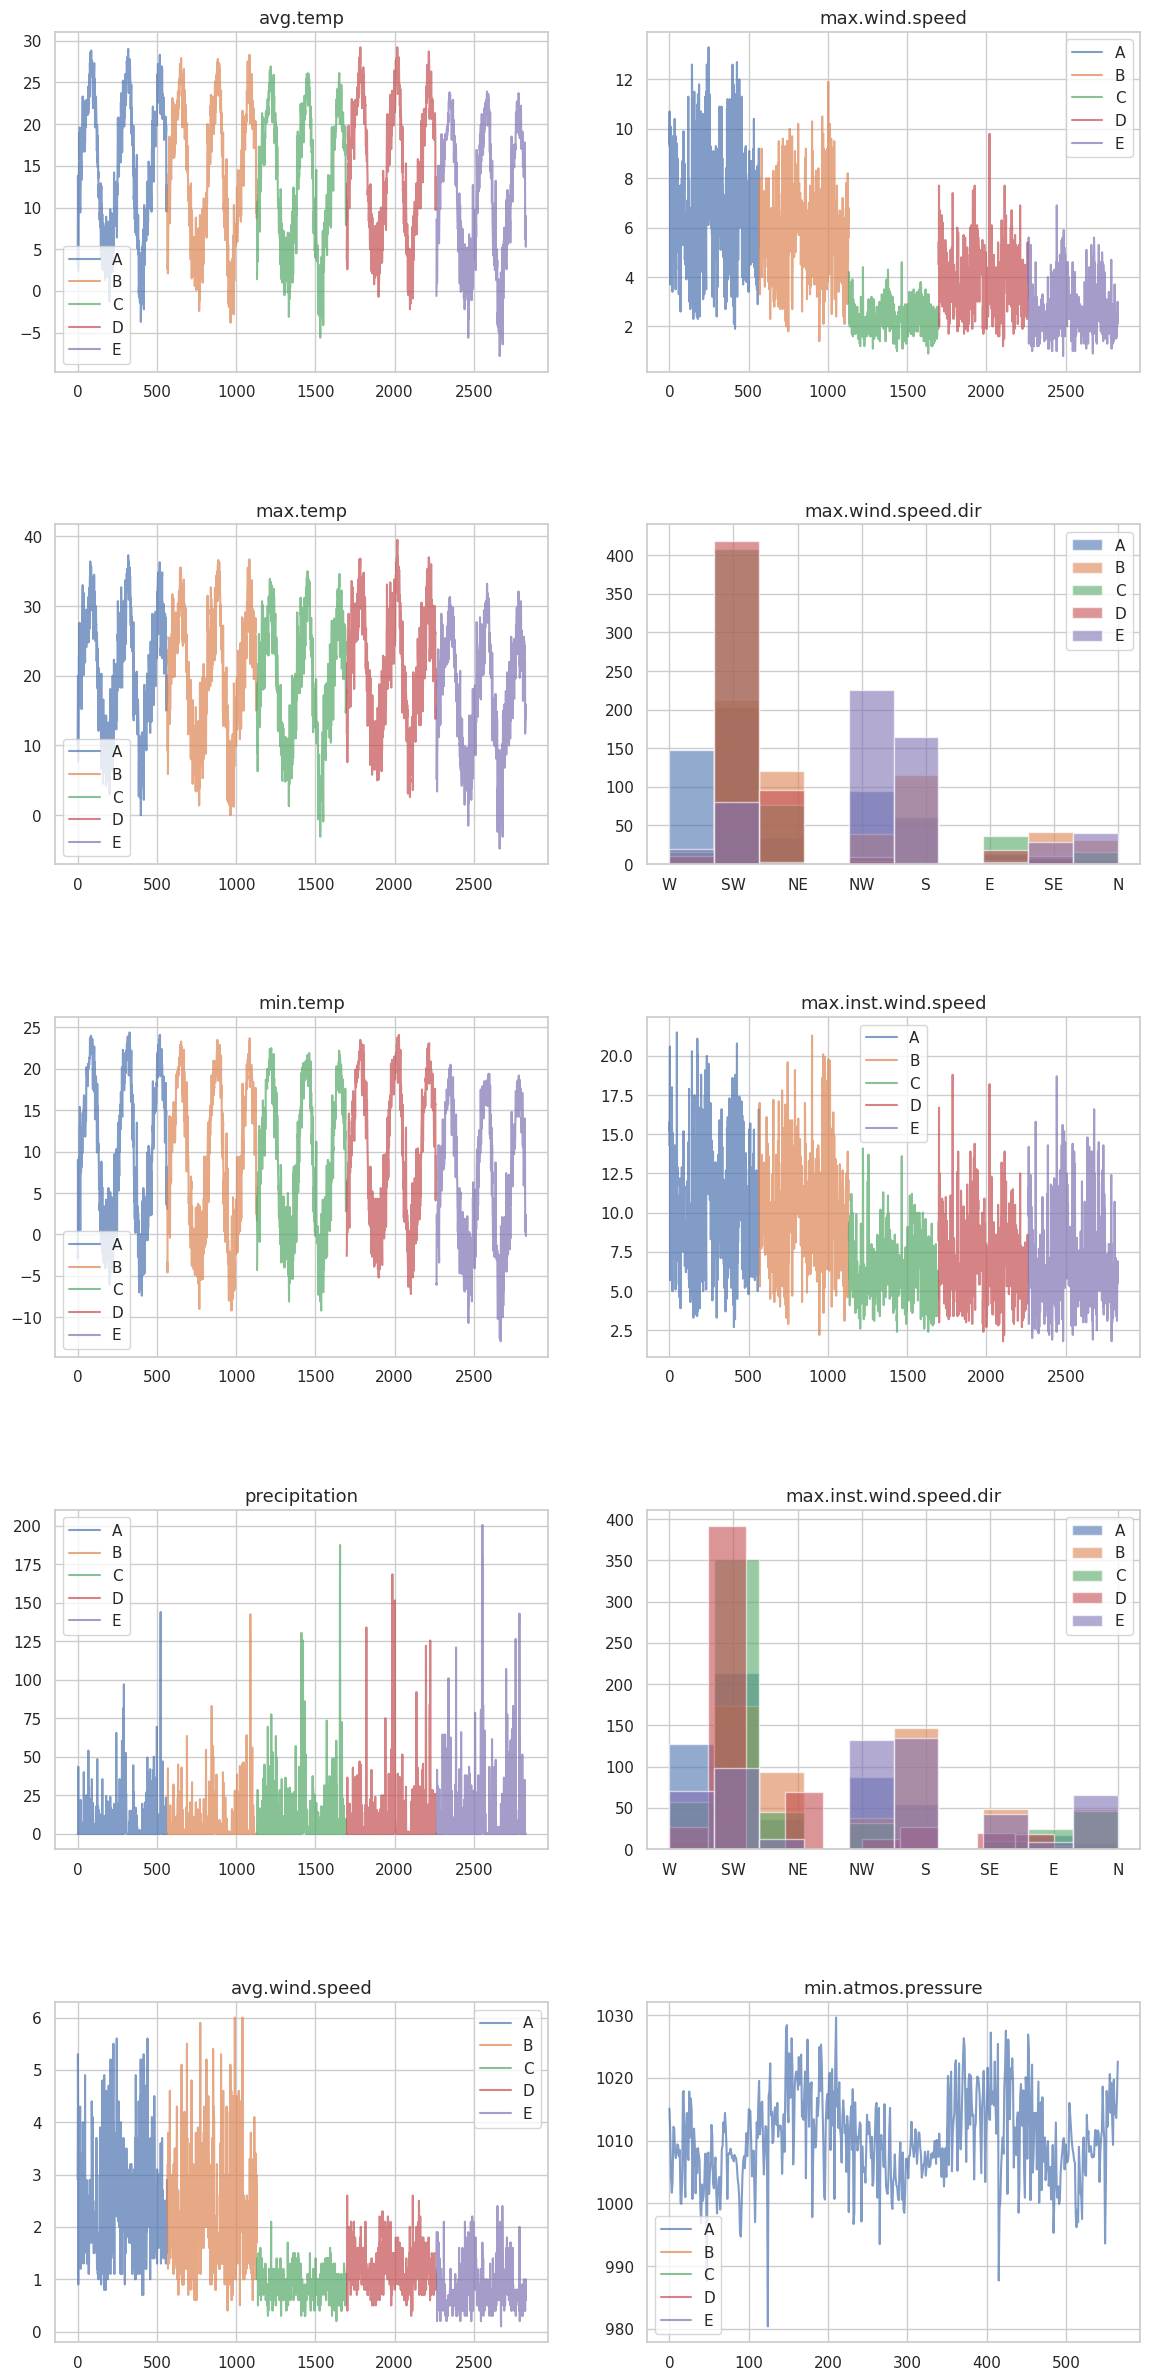

In [ ]:
fig, axes = plt.subplots(5,2,figsize=(14, 30), dpi=100)

for i, col_name in enumerate(train_all_lvls.columns[2:]):
    if train_all_lvls[col_name].dtype == 'O':
        train_all_lvls.groupby('region')[col_name].hist(ax=axes[i%5][i//5], alpha=0.6);
        axes[i%5][i//5].legend(["A", "B", "C", "D", "E"]);
    else:
        train_all_lvls.groupby('region')[col_name].plot(ax=axes[i%5][i//5], alpha=0.7);
        axes[i%5][i//5].legend();
    axes[i%5][i//5].set_title(f'{col_name}', fontsize=13);
    plt.subplots_adjust(hspace=0.45)

### As it is quite visible that minimum atmospheric pressure data is missing from Regions B,C,D and E respectively.

# **Plotting Features of Testing Datasets**

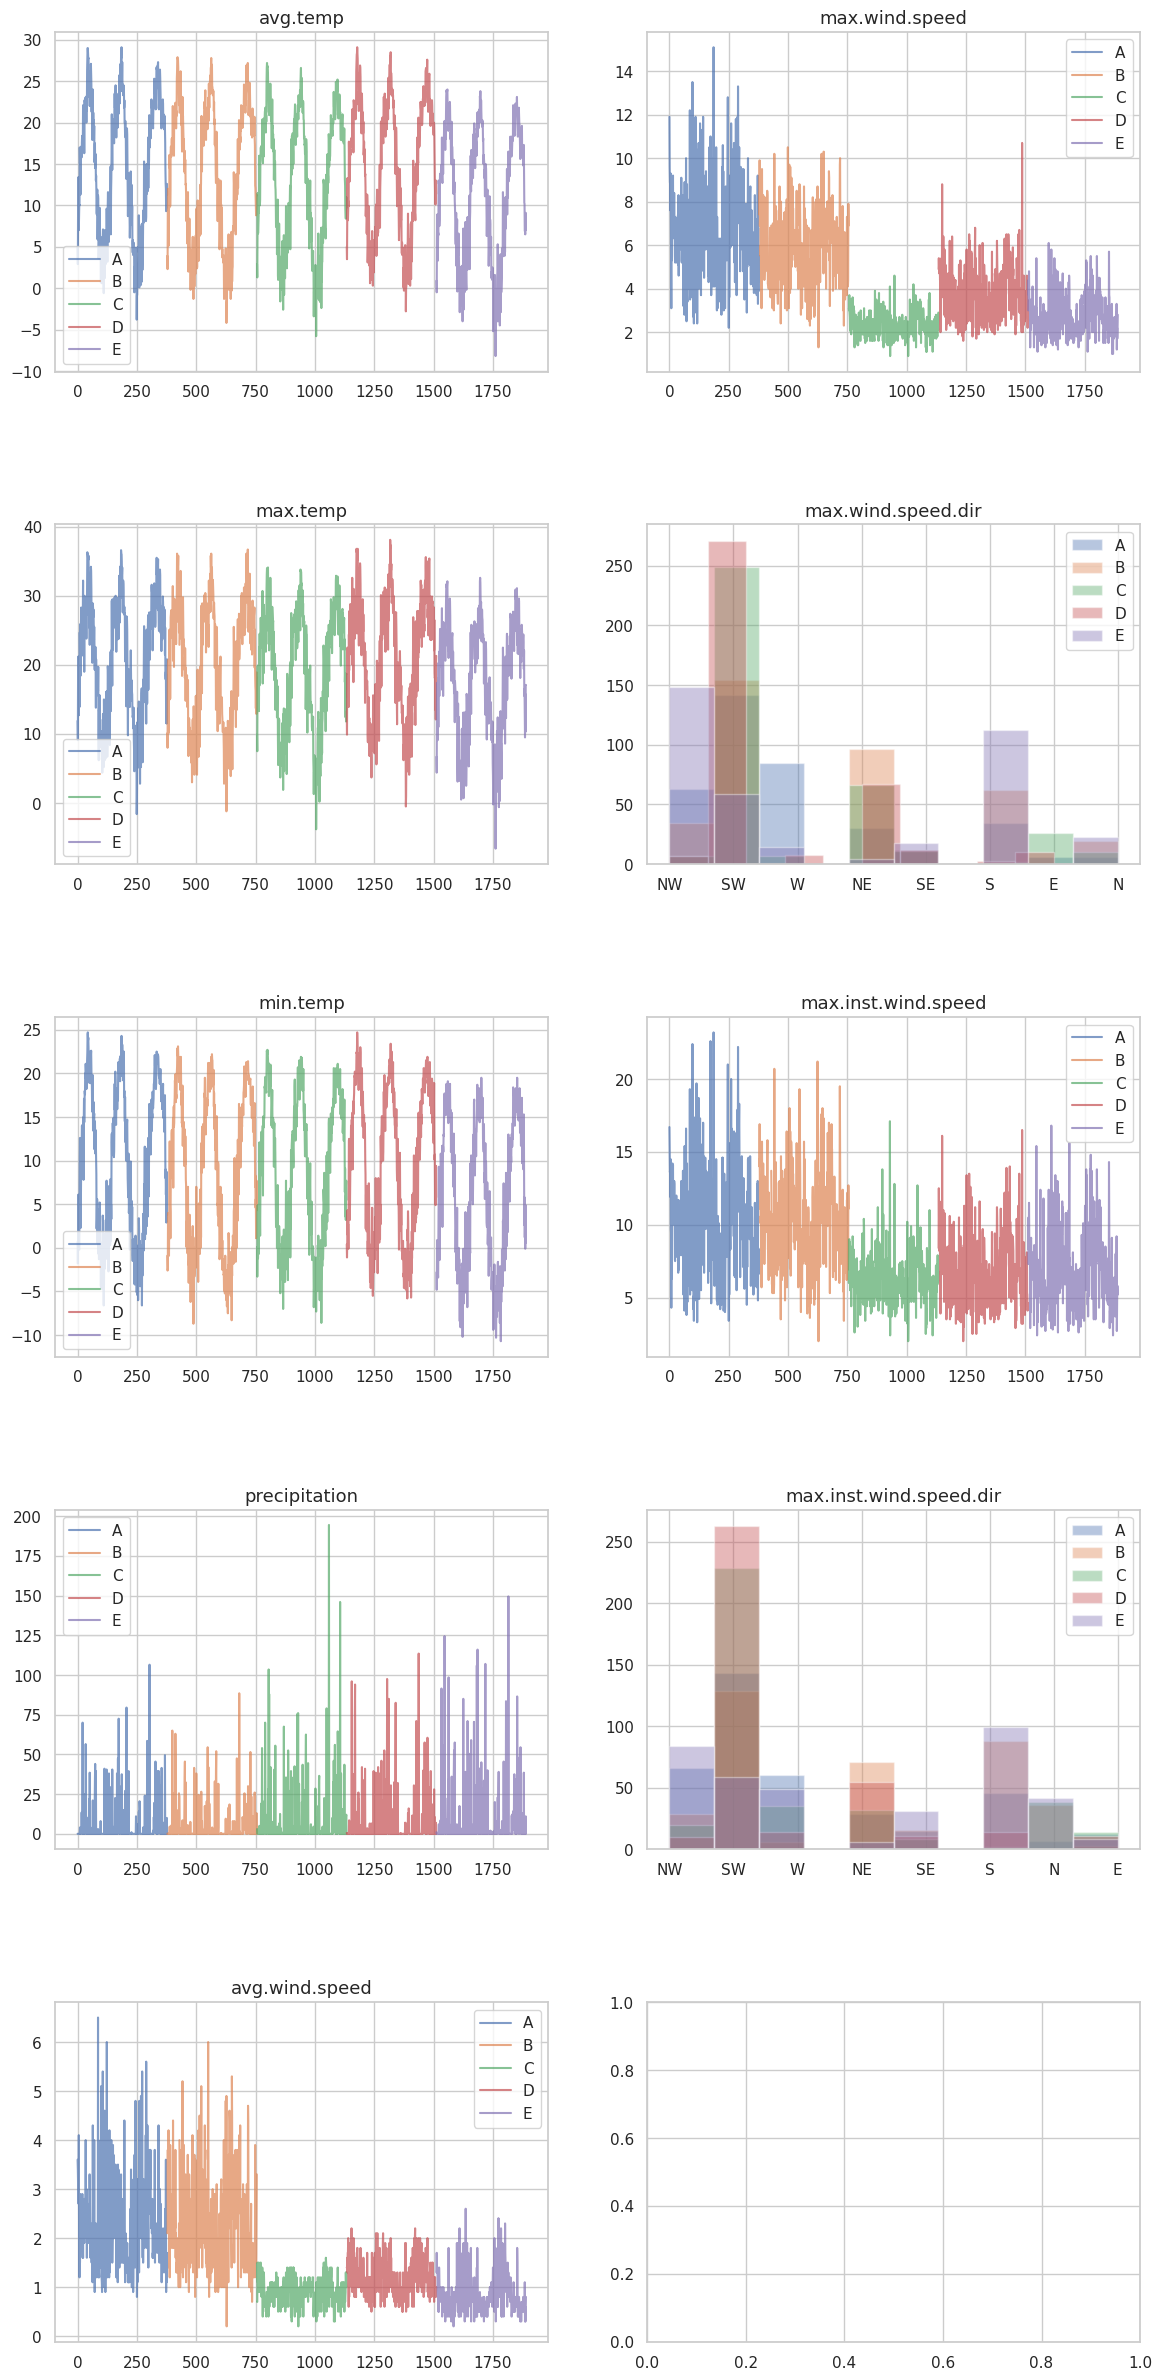

In [ ]:
fig, axes = plt.subplots(5,2,figsize=(14, 30), dpi=100)

for i, col_name in enumerate(test_all_lvls.columns[2:-1]):
    if test_all_lvls[col_name].dtype == 'O':
        test_all_lvls.groupby('region')[col_name].hist(ax=axes[i%5][i//5], alpha=0.4);
        axes[i%5][i//5].legend(["A", "B", "C", "D", "E"]);
    else:
        test_all_lvls.groupby('region')[col_name].plot(ax=axes[i%5][i//5], alpha=0.7);
        axes[i%5][i//5].legend();
    axes[i%5][i//5].set_title(f'{col_name}', fontsize=13);
    plt.subplots_adjust(hspace=0.45)

### The values are missing for minimum atmospheric pressure from testing dataset as well

# **Missing Values**

In [ ]:
missing_cols(train_all_lvls)


min.atmos.pressure => 2264 [80.0%]


## **Plotting a heatmap to check missing values in respective features**

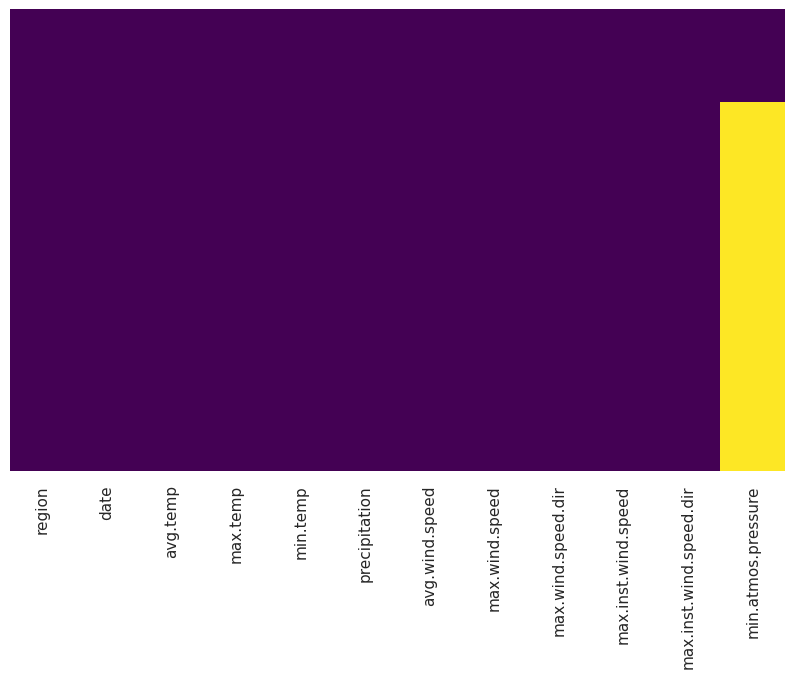

In [ ]:
plt.figure(figsize=(10, 6))
sns.heatmap(train_all_lvls.isnull(), yticklabels=False, cmap='viridis', cbar=False);


## **Plotting histogram of minium atmospheric pressure**

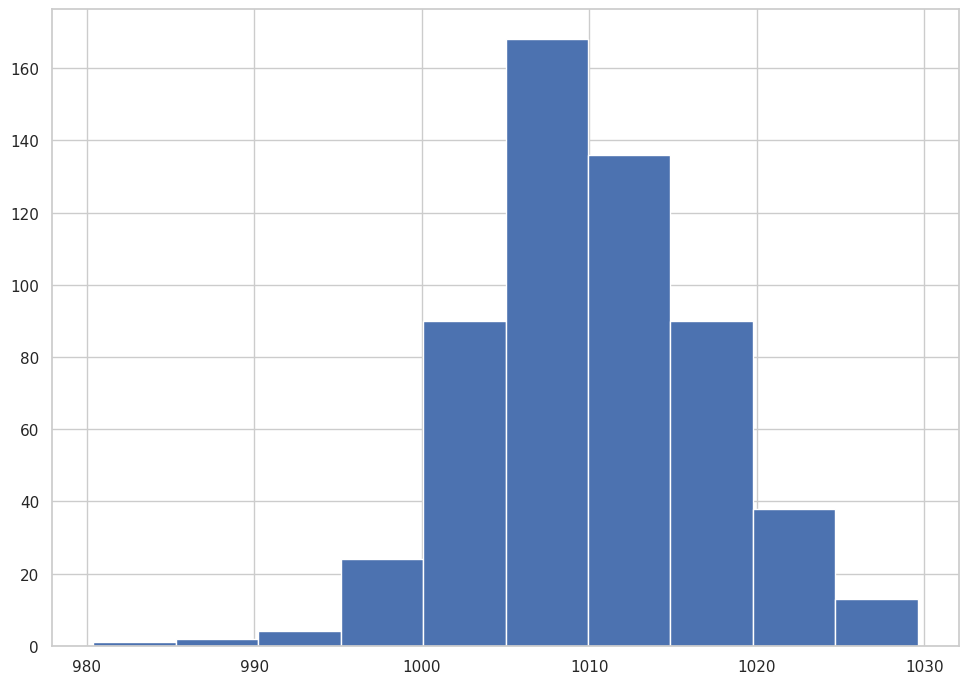

In [ ]:
train_all_lvls['min.atmos.pressure'].hist();

###As there is a large amount of data missing in minimum atmospheric pressure,next step should be to perform feature elimination and drop the column of minimum atmospheric pressure as there is no avaliability of respective data based on regions.

In [ ]:
train_all_lvls = train_all_lvls.drop(['min.atmos.pressure'],axis=1)
train_all_lvls

,region,date,avg.temp,max.temp,min.temp,precipitation,avg.wind.speed,max.wind.speed,max.wind.speed.dir,max.inst.wind.speed,max.inst.wind.speed.dir
0,A,229b70a3,3.3,10.2,-2.4,0.0,2.9,9.3,W,14.3,W
1,A,3134f4ff,5.7,13.7,-2.9,0.0,3.6,10.7,W,15.8,W
2,A,dbfaf910,13.8,20.0,9.0,0.0,5.3,9.4,SW,15.2,W
3,A,3aea0cf0,11.4,19.3,5.8,0.0,4.2,10.1,SW,20.6,SW
4,A,f0227f56,2.4,7.7,0.3,43.5,0.9,3.7,SW,5.7,SW
...,...,...,...,...,...,...,...,...,...,...,...
2825,E,91b2797d,6.3,13.1,0.3,0.0,0.6,2.2,S,4.3,S
2826,E,b807fd87,6.2,13.5,0.3,0.0,0.8,2.3,SW,6.3,W
2827,E,8e0a48e0,9.0,15.9,2.4,0.0,0.6,2.4,NW,5.7,W
2828,E,9df85983,5.3,13.9,0.1,0.0,1.0,3.0,S,6.9,NW


In [ ]:
test_all_lvls = test_all_lvls.drop(['min.atmos.pressure'],axis=1)
test_all_lvls

,region,date,avg.temp,max.temp,min.temp,precipitation,avg.wind.speed,max.wind.speed,max.wind.speed.dir,max.inst.wind.speed,max.inst.wind.speed.dir
0,A,b92d713a,5.0,11.9,0.7,0.0,3.6,11.9,NW,16.7,NW
1,A,18817005,2.9,9.1,-1.8,0.0,3.4,9.6,SW,15.4,SW
2,A,8e19dc3c,9.8,18.9,0.4,0.0,3.1,8.9,W,13.6,W
3,A,6f0929dc,13.4,21.2,6.1,0.0,3.4,8.8,SW,13.8,SW
4,A,c7506622,9.1,16.3,2.4,0.0,2.7,7.6,NW,11.9,NW
...,...,...,...,...,...,...,...,...,...,...,...
1885,E,01a1b150,6.9,9.5,4.3,1.5,0.3,1.2,S,2.7,SE
1886,E,90b49549,6.5,15.8,-0.1,0.0,0.6,2.2,SE,4.7,S
1887,E,15bc4979,7.9,10.3,3.5,9.5,0.3,1.7,SW,5.8,S
1888,E,b4104846,9.1,17.1,4.9,11.0,0.6,2.1,SW,5.8,NW


In [ ]:
#mean_atmos = train_all_lvls['min.atmos.pressure'].mean()

In [ ]:
#train_all_lvls.fillna(mean_atmos, inplace=True)

In [ ]:
missing_cols(train_all_lvls)

no missing values


In [ ]:
missing_cols(test_all_lvls)

avg.temp => 2 [0.11%]
max.temp => 2 [0.11%]
min.temp => 2 [0.11%]
precipitation => 2 [0.11%]
avg.wind.speed => 2 [0.11%]
max.wind.speed => 2 [0.11%]
max.inst.wind.speed => 2 [0.11%]


### As there are minimal missing values within  test dataset feature, in next step missing values are imputed with mean values of respective features within the columns having missing values.

In [ ]:
mean_avg_temp = test_all_lvls['avg.temp'].mean()
mean_max_temp = test_all_lvls['max.temp'].mean()
mean_min_temp = test_all_lvls['min.temp'].mean()
mean_precipitation = test_all_lvls['precipitation'].mean()
mean_avg_wind_speed = test_all_lvls['avg.wind.speed'].mean()
mean_max_wind_speed = test_all_lvls['max.wind.speed'].mean()
mean_inst_wind_speed = test_all_lvls['max.inst.wind.speed'].mean()

In [ ]:
test_all_lvls['avg.temp'].fillna(mean_avg_temp, inplace=True)
test_all_lvls['max.temp'].fillna(mean_max_temp, inplace=True)
test_all_lvls['min.temp'].fillna(mean_min_temp, inplace=True)
test_all_lvls['precipitation'].fillna(mean_precipitation, inplace=True)
test_all_lvls['avg.wind.speed'].fillna(mean_avg_wind_speed, inplace=True)
test_all_lvls['max.wind.speed'].fillna(mean_max_wind_speed, inplace=True)
test_all_lvls['max.inst.wind.speed'].fillna(mean_inst_wind_speed, inplace=True)

In [ ]:
missing_cols(test_all_lvls)

no missing values


# Feature Engineering

In [ ]:
train_all_lvls = train_all_lvls.merge(labels_df, on="date")

In [ ]:
train_all_lvls.dtypes

region                      object
date                        object
avg.temp                   float64
max.temp                   float64
min.temp                   float64
precipitation              float64
avg.wind.speed             float64
max.wind.speed             float64
max.wind.speed.dir          object
max.inst.wind.speed        float64
max.inst.wind.speed.dir     object
label                       object
dtype: object

### Converting the categorical features, including the target variable to a numerical format using LabelEncoder() function on labels

In [ ]:
le = LabelEncoder()
le.fit(train_all_lvls['label'])
le_name_map = dict(zip(le.classes_, le.transform(le.classes_)))
le_name_map

{'H': 0, 'L': 1, 'N': 2}

In [ ]:
train_all_lvls.select_dtypes('object').columns

Index(['region', 'date', 'max.wind.speed.dir', 'max.inst.wind.speed.dir',
       'label'],
      dtype='object')

### There is an interesting new feature engineered called Beaufort Scale.

### **Beaufort scale** is an empirical measure that relates wind speed to observed conditions at sea or on land.

In [ ]:
test_all_lvls.select_dtypes('object').columns

Index(['region', 'date', 'max.wind.speed.dir', 'max.inst.wind.speed.dir'], dtype='object')

In [ ]:
BEAUFORT = [
    (0, 0, 0.3),
    (1, 0.3, 1.6),
    (2, 1.6, 3.4),
    (3, 3.4, 5.5),
    (4, 5.5, 8),
    (5, 8, 10.8),
    (6, 10.8, 13.9),
    (7, 13.9, 17.2),
    (8, 17.2, 20.8),
    (9, 20.8, 24.5),
    (10, 24.5, 28.5),
    (11, 28.5, 33),
    (12, 33, 200),
]



def feature_eng(df):
    le = LabelEncoder()
    
    cat_cols = df.select_dtypes("object").columns[2:]

    for col in cat_cols:
        if df[col].dtype == "object":
            df[col] = le.fit_transform(df[col])

    for item in BEAUFORT:
        df.loc[
            (df["avg.wind.speed"] >= item[1]) & (df["avg.wind.speed"] < item[2]),
            "beaufort_scale",
        ] = item[0]

    df['beaufort_scale'] = df['beaufort_scale'].astype(int)

    return df

The function performs the following operations:

1. **le = LabelEncoder()** - This creates an instance of the LabelEncoder class from the scikit-learn library. This will be used to encode categorical variables.

2. **cat_cols = df.select_dtypes("object").columns[2:] **- This selects the names of all columns in the DataFrame that have a data type of "object" and are not the first two columns (presumably the first two columns are some kind of identifier or index). These are the columns that will be encoded using the LabelEncoder object created in the previous step.

3. **for col in cat_cols: ...** - This loops over each of the categorical columns selected in the previous step. If the data type of the column is "object" (which it should be, since that's how the column was selected), the function uses the fit_transform() method of the LabelEncoder object to encode the column.

4. **for item in BEAUFORT: ...** - This loops over each item in a list called BEAUFORT. Each item in the list is a tuple containing a Beaufort Scale category (0 to 12) and the wind speed range for that category. The function then uses the loc[] method to select rows in the DataFrame where the wind speed falls within the specified range for that Beaufort Scale category, and assigns the corresponding category value to a new column called "beaufort_scale".

5. df['beaufort_scale'] = df['beaufort_scale'].astype(int) - This converts the "beaufort_scale" column from floating point values to integers.


In [ ]:
#test_all_lvls = test_all_lvls.replace([np.inf, -np.inf], np.nan) # replace inf values with NaN
#test_all_lvls = test_all_lvls.dropna()

## Applying feature engineering steps on training and testing data

In [ ]:
train = feature_eng(train_all_lvls)
test = feature_eng(test_all_lvls)

# **Preparing train data**

In [ ]:
train.head()

,region,date,avg.temp,max.temp,min.temp,precipitation,avg.wind.speed,max.wind.speed,max.wind.speed.dir,max.inst.wind.speed,max.inst.wind.speed.dir,label,beaufort_scale
0,A,229b70a3,3.3,10.2,-2.4,0.0,2.9,9.3,7,14.3,7,2,2
1,B,229b70a3,2.6,9.3,-3.3,0.0,2.8,6.3,3,11.4,3,2,2
2,C,229b70a3,1.4,9.0,-4.3,0.0,1.0,2.9,6,8.2,1,2,1
3,D,229b70a3,3.7,11.7,-2.6,0.0,1.5,5.4,6,9.4,4,2,1
4,E,229b70a3,-0.6,5.2,-5.9,0.0,1.5,3.8,3,9.8,7,2,1


In [ ]:
train.dtypes

region                      object
date                        object
avg.temp                   float64
max.temp                   float64
min.temp                   float64
precipitation              float64
avg.wind.speed             float64
max.wind.speed             float64
max.wind.speed.dir           int64
max.inst.wind.speed        float64
max.inst.wind.speed.dir      int64
label                        int64
beaufort_scale               int64
dtype: object

### Pivoting data into the longer format in both training and test datasets, which means instead of the region being a column, each feature will have its own region, such as avg.temp_A, avg.temp_B, until avg.temp_E for the rest of the features.

### This way the data will be in the right shape to build the model.

### pivot_table() function in pandas is used to achieve that.

In [ ]:
train = train.pivot_table(index=["date", "label"], columns="region")
train = pd.DataFrame(train.to_records())
train.head()

,date,label,"('avg.temp', 'A')","('avg.temp', 'B')","('avg.temp', 'C')","('avg.temp', 'D')","('avg.temp', 'E')","('avg.wind.speed', 'A')","('avg.wind.speed', 'B')","('avg.wind.speed', 'C')",...,"('min.temp', 'A')","('min.temp', 'B')","('min.temp', 'C')","('min.temp', 'D')","('min.temp', 'E')","('precipitation', 'A')","('precipitation', 'B')","('precipitation', 'C')","('precipitation', 'D')","('precipitation', 'E')"
0,00173aec,2,18.7,17.6,16.9,19.5,14.3,1.6,1.8,0.9,...,14.9,12.5,12.9,16.4,9.0,1.0,1.5,1.5,0.0,4.5
1,0083f291,1,13.1,12.6,12.0,13.0,10.7,1.4,1.0,0.7,...,11.3,11.1,10.6,12.1,8.5,50.0,46.5,49.0,45.5,63.0
2,014cfe7b,2,19.9,19.0,17.5,19.9,16.2,3.7,3.6,0.7,...,16.1,13.5,15.8,16.3,12.4,18.0,17.0,63.5,19.0,32.0
3,01947c8e,2,21.6,20.2,20.5,21.3,17.6,1.6,1.2,1.1,...,15.8,14.2,15.5,15.9,11.5,0.0,1.0,0.0,0.0,0.0
4,0258884d,2,15.2,13.9,13.9,15.8,11.1,2.5,2.3,1.2,...,10.3,5.6,8.9,10.4,5.3,0.0,0.0,0.0,0.0,0.0


In [ ]:
def replace_all(text):
    d = { "('": "", "', '": "_", "')" : "",}
    for i, j in d.items():
        text = text.replace(i, j)
    return text

# ('avg.temp', 'A') -> avg.temp_A

test_str = "('avg.temp', 'A')"
replace_all(test_str)

'avg.temp_A'

In [ ]:
train.columns = list(map(replace_all, train.columns))

In [ ]:
train.columns

Index(['date', 'label', 'avg.temp_A', 'avg.temp_B', 'avg.temp_C', 'avg.temp_D',
       'avg.temp_E', 'avg.wind.speed_A', 'avg.wind.speed_B',
       'avg.wind.speed_C', 'avg.wind.speed_D', 'avg.wind.speed_E',
       'beaufort_scale_A', 'beaufort_scale_B', 'beaufort_scale_C',
       'beaufort_scale_D', 'beaufort_scale_E', 'max.inst.wind.speed_A',
       'max.inst.wind.speed_B', 'max.inst.wind.speed_C',
       'max.inst.wind.speed_D', 'max.inst.wind.speed_E',
       'max.inst.wind.speed.dir_A', 'max.inst.wind.speed.dir_B',
       'max.inst.wind.speed.dir_C', 'max.inst.wind.speed.dir_D',
       'max.inst.wind.speed.dir_E', 'max.temp_A', 'max.temp_B', 'max.temp_C',
       'max.temp_D', 'max.temp_E', 'max.wind.speed_A', 'max.wind.speed_B',
       'max.wind.speed_C', 'max.wind.speed_D', 'max.wind.speed_E',
       'max.wind.speed.dir_A', 'max.wind.speed.dir_B', 'max.wind.speed.dir_C',
       'max.wind.speed.dir_D', 'max.wind.speed.dir_E', 'min.temp_A',
       'min.temp_B', 'min.temp_C', 'min.t

In [ ]:
test = test.pivot_table(index=["date"], columns="region")
test = pd.DataFrame(test.to_records())
test.columns = list(map(replace_all, test.columns))

In [ ]:
train

,date,label,avg.temp_A,avg.temp_B,avg.temp_C,avg.temp_D,avg.temp_E,avg.wind.speed_A,avg.wind.speed_B,avg.wind.speed_C,...,min.temp_A,min.temp_B,min.temp_C,min.temp_D,min.temp_E,precipitation_A,precipitation_B,precipitation_C,precipitation_D,precipitation_E
0,00173aec,2,18.7,17.6,16.9,19.5,14.3,1.6,1.8,0.9,...,14.9,12.5,12.9,16.4,9.0,1.0,1.5,1.5,0.0,4.5
1,0083f291,1,13.1,12.6,12.0,13.0,10.7,1.4,1.0,0.7,...,11.3,11.1,10.6,12.1,8.5,50.0,46.5,49.0,45.5,63.0
2,014cfe7b,2,19.9,19.0,17.5,19.9,16.2,3.7,3.6,0.7,...,16.1,13.5,15.8,16.3,12.4,18.0,17.0,63.5,19.0,32.0
3,01947c8e,2,21.6,20.2,20.5,21.3,17.6,1.6,1.2,1.1,...,15.8,14.2,15.5,15.9,11.5,0.0,1.0,0.0,0.0,0.0
4,0258884d,2,15.2,13.9,13.9,15.8,11.1,2.5,2.3,1.2,...,10.3,5.6,8.9,10.4,5.3,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
561,fe2a1385,1,2.9,1.6,1.4,3.4,0.4,1.2,0.9,0.7,...,-4.0,-5.9,-2.8,-3.4,-5.9,0.0,0.0,0.0,0.0,0.0
562,fe6dd99c,1,2.9,2.9,3.9,2.9,0.2,1.6,3.9,1.0,...,1.7,1.4,1.9,1.0,-1.2,2.0,1.0,2.0,4.0,8.0
563,ff88c3dd,1,9.8,8.9,9.0,10.2,6.3,1.9,1.5,1.4,...,1.5,-0.1,2.0,2.5,-1.9,0.0,0.0,0.0,0.0,0.0
564,ff929090,2,10.4,8.1,7.1,11.0,5.7,4.3,4.6,0.9,...,3.4,1.5,-0.6,3.2,-1.6,0.0,3.5,5.5,0.0,1.5


In [ ]:
test

,date,avg.temp_A,avg.temp_B,avg.temp_C,avg.temp_D,avg.temp_E,avg.wind.speed_A,avg.wind.speed_B,avg.wind.speed_C,avg.wind.speed_D,...,min.temp_A,min.temp_B,min.temp_C,min.temp_D,min.temp_E,precipitation_A,precipitation_B,precipitation_C,precipitation_D,precipitation_E
0,0001f2fd,21.1,20.7,20.4,21.4,18.4,1.1,0.9,0.6,0.9,...,17.2,16.8,17.3,18.2,14.7,41.5,23.5,38.0,39.5,54.5
1,00177dc1,20.6,20.5,19.1,21.1,17.8,1.7,1.4,0.8,1.0,...,18.3,17.1,15.4,18.8,13.3,38.0,20.5,33.5,34.5,30.5
2,00b3a048,7.8,6.4,7.2,8.0,4.8,1.5,3.1,0.7,0.6,...,3.9,1.4,3.8,6.1,-0.2,4.0,8.0,4.5,11.5,8.0
3,013f131b,29.0,27.8,27.2,28.2,23.9,2.4,1.8,0.9,1.7,...,24.5,22.2,22.5,22.3,18.8,0.0,0.0,0.0,0.0,0.0
4,01a1b150,9.3,9.2,8.8,10.2,6.9,0.9,1.9,0.9,0.8,...,7.5,5.6,5.9,8.7,4.3,0.0,0.5,0.5,2.0,1.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
373,fd48b23a,19.1,18.1,19.2,19.9,17.3,1.4,1.3,0.5,0.7,...,17.5,16.6,17.0,18.9,15.3,49.5,26.0,43.5,28.0,38.5
374,fd52bb91,17.3,17.2,16.8,17.3,12.9,2.9,2.9,1.1,2.2,...,11.1,11.5,10.2,10.3,6.3,0.5,0.5,1.5,0.0,2.5
375,fe708035,15.7,15.1,15.4,16.6,13.8,0.9,1.9,1.0,0.8,...,13.7,13.0,13.7,14.9,11.9,20.5,20.0,20.5,23.0,31.5
376,ff11ac29,11.2,10.5,7.8,11.3,6.7,6.5,3.7,1.0,1.7,...,4.1,3.6,1.3,4.6,-1.0,3.0,5.5,4.5,3.5,6.0


# **Building LGBM Baseline Model**


In [ ]:
train.dtypes

date                          object
label                          int64
avg.temp_A                   float64
avg.temp_B                   float64
avg.temp_C                   float64
avg.temp_D                   float64
avg.temp_E                   float64
avg.wind.speed_A             float64
avg.wind.speed_B             float64
avg.wind.speed_C             float64
avg.wind.speed_D             float64
avg.wind.speed_E             float64
beaufort_scale_A               int64
beaufort_scale_B               int64
beaufort_scale_C               int64
beaufort_scale_D               int64
beaufort_scale_E               int64
max.inst.wind.speed_A        float64
max.inst.wind.speed_B        float64
max.inst.wind.speed_C        float64
max.inst.wind.speed_D        float64
max.inst.wind.speed_E        float64
max.inst.wind.speed.dir_A      int64
max.inst.wind.speed.dir_B      int64
max.inst.wind.speed.dir_C      int64
max.inst.wind.speed.dir_D      int64
max.inst.wind.speed.dir_E      int64
m

In [ ]:
categoricals = list(train.select_dtypes(include=['int64']).columns)
categoricals.remove("label")
numericals = list(train.select_dtypes(include=['float64']).columns)

feat_cols = categoricals + numericals

**categoricals** = list(train.select_dtypes(include=['int64']).columns) - This selects the names of all columns in the train DataFrame that have a data type of "int64" (i.e., integer columns) and assigns them to the categoricals variable as a list.

**categoricals.remove("label")** - This removes the string "label" from the categoricals list. This is presumably because "label" is the name of the target variable that we want to predict, and we don't want it to be included as a feature.

**numericals** = list(train.select_dtypes(include=['float64']).columns) - This selects the names of all columns in the train DataFrame that have a data type of "float64" (i.e., floating-point columns) and assigns them to the numericals variable as a list.

**feat_cols** = categoricals + numericals - This concatenates the categoricals and numericals lists to create a list of all feature columns, which is assigned to the feat_cols variable.

In [ ]:
X = train[feat_cols]
y = train['label']
 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

**X = train[feat_cols]** - This creates a new DataFrame called X that contains only the columns specified in the feat_cols list. This will be used as the input features for the machine learning model.

**y = train['label']** - This creates a new Series called y that contains only the values from the "label" column of the train DataFrame. This will be used as the target variable for the machine learning model.

**X_train, X_test, y_train, y_test** = train_test_split(X, y, test_size = 0.3, random_state = 0) - This uses the train_test_split() function from scikit-learn to split the X and y data into training and testing sets. The test_size argument specifies the proportion of the data to use for testing (30% in this case), and the random_state argument sets the random seed for reproducibility.

In [ ]:
clf = lgb.LGBMClassifier()

clf.fit(X_train, y_train)

LGBMClassifier()

**clf = lgb.LGBMClassifier()** - This creates a new instance of the LightGBM classifier from the LightGBM library.

**clf.fit(X_train, y_train**) - This fits the LightGBM classifier to the training data (X_train and y_train) using the fit() method. After this line of code is executed, clf will be a trained machine learning model that can be used to make predictions on new data.

# **Model Prediction**

In [ ]:
y_pred=clf.predict(X_test)

# **Model performance**

In [ ]:
acc_score = accuracy_score(y_pred, y_test)
recall_score = recall_score(y_pred, y_test, average='macro')
print(f"Accuracy: {acc_score}, recall: {recall_score}")

Accuracy: 0.6058823529411764, recall: 0.44188034188034186


In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.30      0.33      0.32         9
           1       0.33      0.19      0.24        52
           2       0.69      0.83      0.75       109

    accuracy                           0.61       170
   macro avg       0.44      0.45      0.44       170
weighted avg       0.56      0.61      0.57       170



## You might notice that there are three values for the overall F1-score 0.61, 0.54, 0.57.

## In an imbalanced dataset where all classes are equally important, macro average is a good choice as it treats all classes equally.



# As this a baseline mode the precision, recall and f1-score are farily low currently, however the model is further tuned in the different notebook to show actual results

# **Confusion Matrix**

In [ ]:
class_names = le_name_map.keys()

Confusion matrix, without normalization
[[ 3  3  3]
 [ 5 10 37]
 [ 2 17 90]]
Normalized confusion matrix
[[0.33333333 0.33333333 0.33333333]
 [0.09615385 0.19230769 0.71153846]
 [0.01834862 0.1559633  0.82568807]]


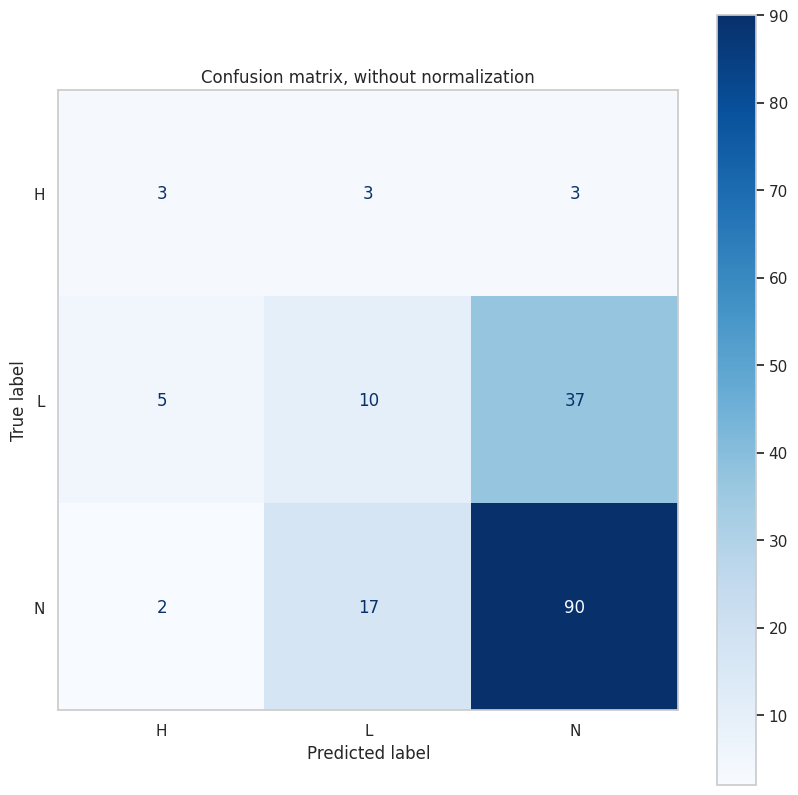

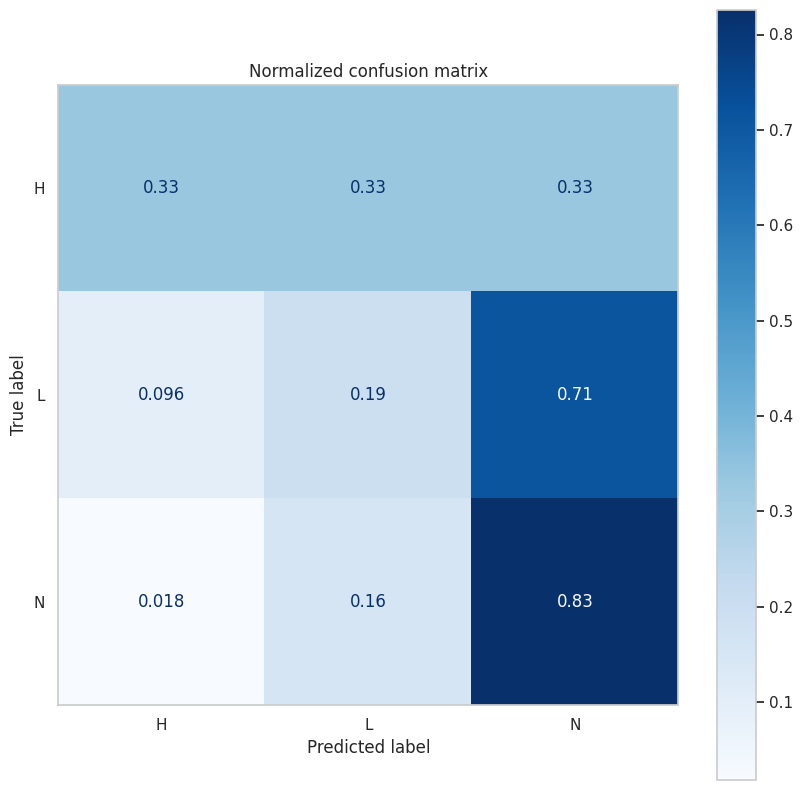

In [ ]:
titles_options = [
    ("Confusion matrix, without normalization", None),
    ("Normalized confusion matrix", "true"),
]
for title, normalize in titles_options:
    fig, ax = plt.subplots(figsize=(10, 10))

    disp = ConfusionMatrixDisplay.from_estimator(
        clf,
        X_test,
        y_test,
        display_labels=class_names,
        cmap=plt.cm.Blues,
        normalize=normalize,
        ax = ax
    )
    disp.ax_.set_title(title)
    disp.ax_.grid(False)

    print(title)
    print(disp.confusion_matrix)

Confusion Matrix has been plotted to evaluate the performance of our model.

A **non-normalized confusion matrix** is simply a count of the number of test samples that were correctly or incorrectly classified by the model, without any further normalization or scaling of the data. Each cell of the matrix represents a count of the number of samples that fall into a particular combination of predicted and actual class labels.

On the other hand, a **normalized confusion matrix** scales the counts so that they are expressed as proportions or percentages of the total number of test samples. This can be useful for comparing the relative performance of different models or for visualizing the distribution of errors across different classes.

As you can see from the shade of the plot, our model is predicting the label N much more than others.


# **Checking for Overfitting**

In [ ]:
print('Training set score: {:.4f}'.format(clf.score(X_train, y_train)))
print('Test set score: {:.4f}'.format(clf.score(X_test, y_test)))

Training set score: 1.0000
Test set score: 0.6059


# **Feature Importance**

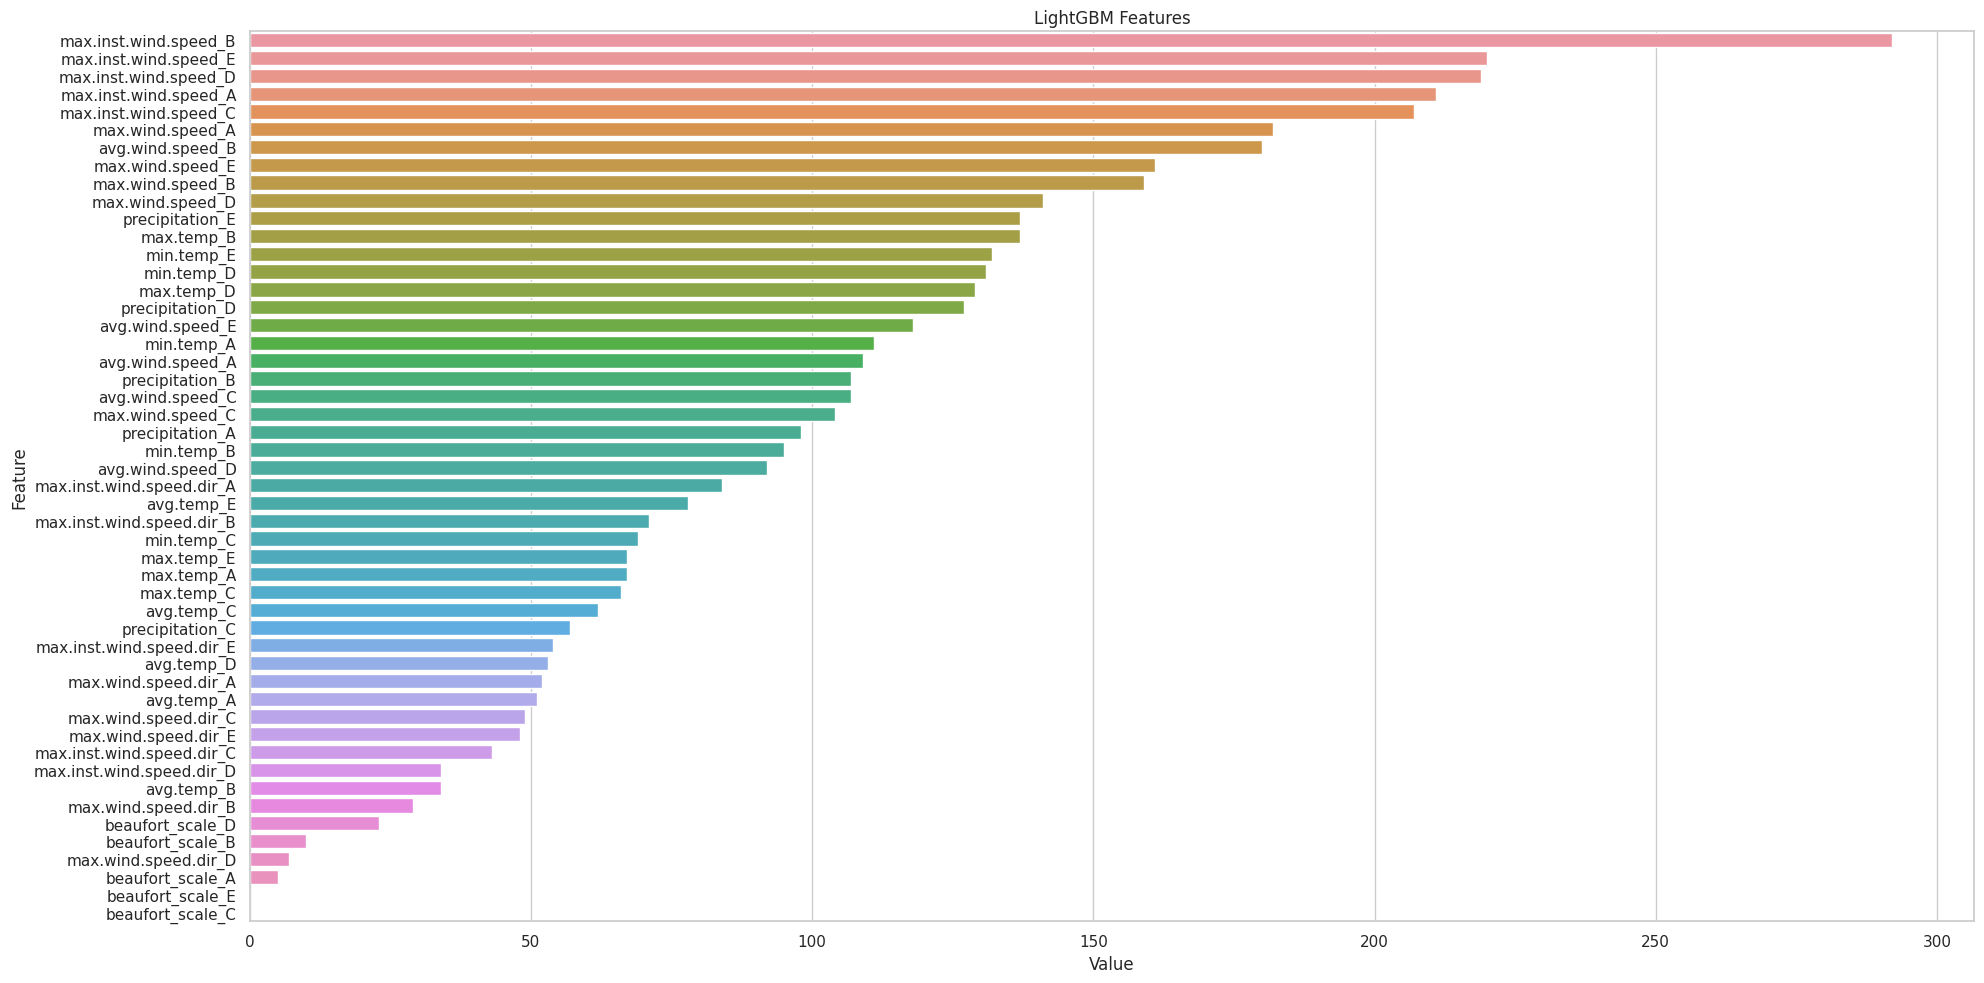

In [ ]:
feature_imp = pd.DataFrame(sorted(zip(clf.feature_importances_,X.columns)), columns=['Value','Feature'])

plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features')
plt.tight_layout()
# plt.savefig('lightgbm_fimp.png')

### From the plot above, the wind speed features and precipitation are the key features that are good predictors.

# **Saving the model**

In [ ]:
joblib.dump(clf, 'lgb1.pkl')

['lgb1.pkl']

# **Predicting on test data**

In [ ]:
X = test[feat_cols]

In [ ]:
test_preds = clf.predict(X)
submission_df = pd.concat([test['date'], pd.DataFrame(test_preds, columns=['label'])], axis=1)
submission_df.head()

,date,label
0,0001f2fd,1
1,00177dc1,1
2,00b3a048,1
3,013f131b,2
4,01a1b150,2


In [ ]:
le_name_map

{'H': 0, 'L': 1, 'N': 2}

### The labels are still encoded as numeric values. Since already there is a  dictionary of the mapping of label names to numeric values, i.e. ‘H’ : 0, the dictionary is reversed to map the numbers to the names.



In [ ]:
inv_map = {v: k for k, v in le_name_map.items()}
inv_map

{0: 'H', 1: 'L', 2: 'N'}

In [ ]:
submission_df['label'] = submission_df['label'].map(inv_map)  
submission_df.head()

,date,label
0,0001f2fd,L
1,00177dc1,L
2,00b3a048,L
3,013f131b,N
4,01a1b150,N


### As you can see the submission_df dataframe gives the gist of our prediction labels on the testing dataset on the respective dates.

# **NOTE**

## This is just the baseline model, the classification model and predictive analytics for weather prediction on respective dates is completed in the "ML_Final_Project_2.ipynb" notebook which shows detailed analysis and building  model with various machine learning techniques.